In [1]:
import torch
import matplotlib.pyplot as plt
import datasets, models, train, utils

In [2]:
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

In [3]:
# create dataloaders
train_all_ds, train_lab_ds, train_unlab_ds, valid_ds, test_ds  = datasets.create_dataloaders()

images.shape=torch.Size([8, 3, 224, 224]), labels.shape=torch.Size([8, 224, 224])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1],
        [2, 2, 2,  ..., 1, 1, 1]], dtype=torch.uint8)


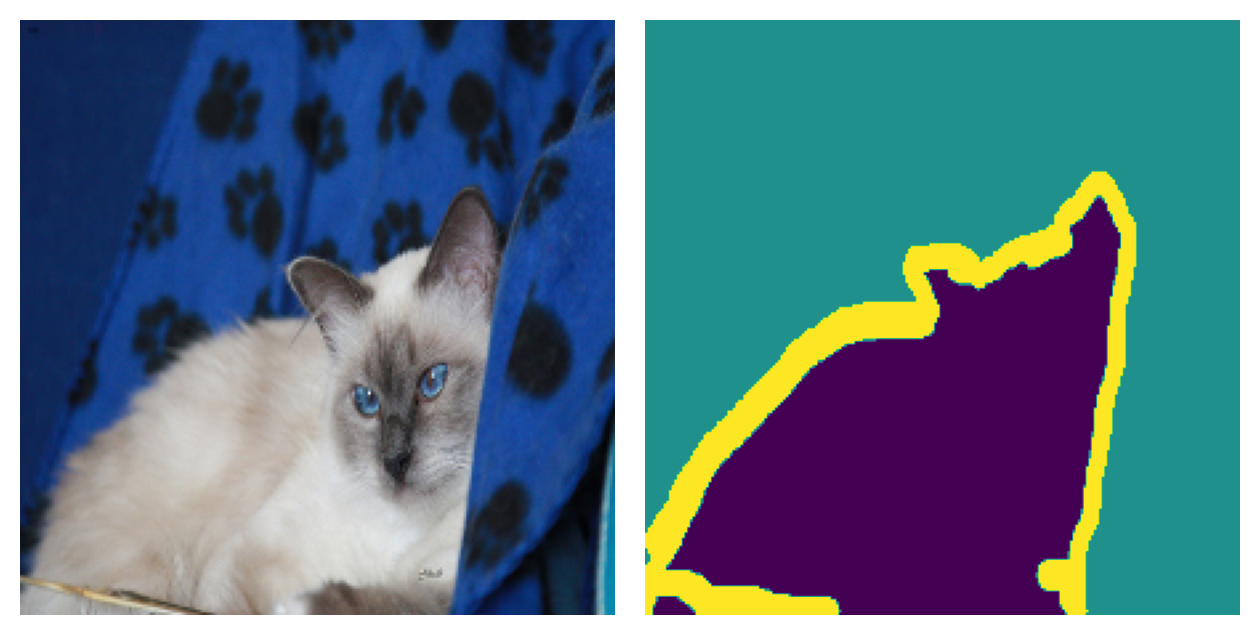

In [4]:
# plot dataset sample
images, labels = next(iter(train_all_ds))
print(f'{images.shape=}, {labels.shape=}')
print(labels[0]) 
#    the labels are:
#    - 0: foreground
#    - 1: background
#    - 2: not classified 
fig, axs = plt.subplots(1, 2)
axs[0].imshow((utils.unnormalize_images(images))[0].permute(1, 2, 0))
axs[1].imshow(labels[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
%%time
# test model
model = models.load_deeplab()
logits = model(images)['out'][:, 0]
logits.shape

CPU times: user 3.43 s, sys: 904 ms, total: 4.33 s
Wall time: 2.29 s


torch.Size([8, 224, 224])

In [29]:
# checking if deeplab head gets different weights
model1 = models.load_deeplab(use_imagenet_weights=True, large_resnet=False)
model2 = models.load_deeplab(use_imagenet_weights=True, large_resnet=False)

for name in model1.classifier.state_dict().keys():
            
            if not torch.allclose(
                model1.classifier.state_dict()[name], model2.classifier.state_dict()[name]
            ):
                    print('layer NOT the same:', name)
                    print(model1.classifier.state_dict()[name])
                    print(model2.classifier.state_dict()[name])

            else:
                print('layer the same:',name)  
                print(model2.classifier.state_dict()[name])       
                # looks like only 0 and 1 init weights match up, random ones indeed don't  

layer NOT the same: 0.convs.0.0.weight
tensor([[[[-0.0083]],

         [[-0.0053]],

         [[-0.0125]],

         ...,

         [[ 0.0008]],

         [[-0.0212]],

         [[-0.0182]]],


        [[[-0.0077]],

         [[-0.0057]],

         [[-0.0016]],

         ...,

         [[ 0.0109]],

         [[ 0.0185]],

         [[-0.0186]]],


        [[[ 0.0146]],

         [[ 0.0188]],

         [[ 0.0100]],

         ...,

         [[ 0.0053]],

         [[ 0.0172]],

         [[ 0.0145]]],


        ...,


        [[[ 0.0147]],

         [[ 0.0026]],

         [[ 0.0026]],

         ...,

         [[ 0.0119]],

         [[ 0.0134]],

         [[-0.0101]]],


        [[[ 0.0170]],

         [[-0.0066]],

         [[-0.0078]],

         ...,

         [[-0.0112]],

         [[ 0.0009]],

         [[ 0.0040]]],


        [[[-0.0190]],

         [[-0.0104]],

         [[ 0.0083]],

         ...,

         [[ 0.0057]],

         [[ 0.0109]],

         [[-0.0177]]]])
tensor([[[[-0.002

## Test CutMix function

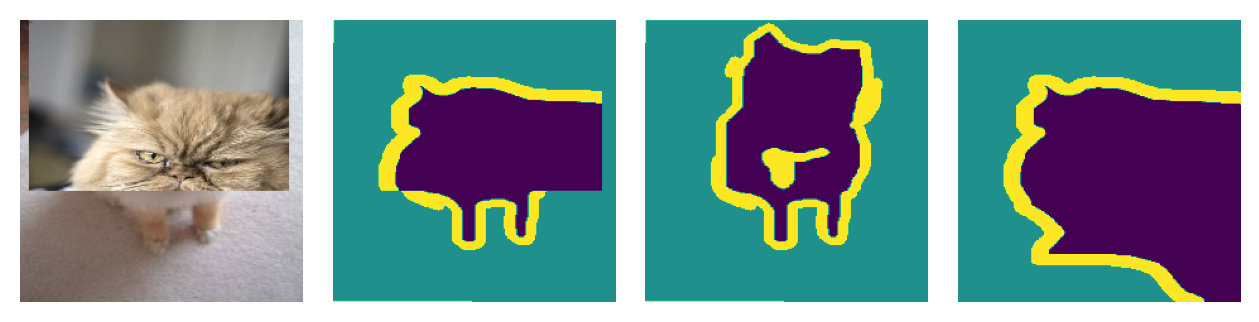

In [15]:

images, labels = next(iter(train_all_ds))

cutmix_input, input_a, input_b, cutmix_target_a, cutmix_target_b, mask = utils.cutmix(images, labels)

test_target = utils.apply_cutmix_mask_to_output(cutmix_target_a, cutmix_target_b, mask)

fig, axs = plt.subplots(1, 4)
axs[0].imshow((utils.unnormalize_images(cutmix_input))[0].permute(1, 2, 0))
axs[1].imshow(test_target[0])
axs[2].imshow(cutmix_target_a[0])
axs[3].imshow(cutmix_target_b[0])
for ax in axs: ax.axis('off')
plt.tight_layout()
plt.show()

In [100]:
set(test_target.flatten())

{tensor(0.),
 tensor(1.),
 tensor(1.8191),
 tensor(0.),
 tensor(0.),
 tensor(2.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.8191),
 tensor(1.),
 tensor(0.1809),
 tensor(0.1809),
 tensor(1.),
 tensor(0.1809),
 tensor(1.),
 tensor(1.),
 tensor(2.),
 tensor(1.6382),
 tensor(0.1809),
 tensor(0.1809),
 tensor(1.1809),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(1.),
 tensor(1.),
 tensor(1.8191),
 tensor(1.),
 tensor(0.1809),
 tensor(0.1809),
 tensor(1.),
 tensor(0.1809),
 tensor(1.),
 tensor(1.),
 tensor(0.8191),
 tensor(1.1809),
 tensor(1.1809),
 tensor(1.),
 tensor(1.8191),
 tensor(0.),
 tensor(1.),
 tensor(0.1809),
 tensor(0.1809),
 tensor(0.1809),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.8191),
 tensor(1.),
 tensor(0.1809),
 tensor(0.1809),
 tensor(1.),
 tensor(0.1809),
 tensor(1.),
 tensor(1.),
 tensor(0.1809),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(1.),
 te